# I’m Something of a Painter Myself

## Brief description of the problem and data (5 pts)

##### Introduction
The purpose of this notebook is to demonstrate how to transfer the distinctive style of Monet's paintings to contemporary photographs using CycleGAN. The core mechanism involves a generator that learns to convert regular photos into images that mimic the artistic style of Monet. Concurrently, a discriminator is trained to differentiate between authentic Monet paintings and the photos that have been transformed by the generator. Through this process, both the generator and the discriminator continuously refine and enhance their capabilities.

The generator works by analyzing the stylistic elements of Monet's artwork and applying these characteristics to photos, effectively creating a fusion of modern photography and classic impressionist painting. The discriminator, on the other hand, acts as a critic, pushing the generator to produce increasingly convincing Monet-style images by flagging those that do not quite meet the mark. This adversarial relationship between the two networks leads to progressive improvement, ultimately achieving high-quality style transfer results.

##### Data:
- The dataset for the "GANs: Getting Started" competition on Kaggle consists of two primary directories: monet_jpg and photo_jpg.

    - monet_jpg: Contains 300 images of paintings by Claude Monet, which will be used as the target style for the GAN to learn and transfer.
    - photo_jpg: Contains 7,028 images of landscapes and scenes, which will be used as the input images for the style transfer process.

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
data_path = './gan-getting-started/'

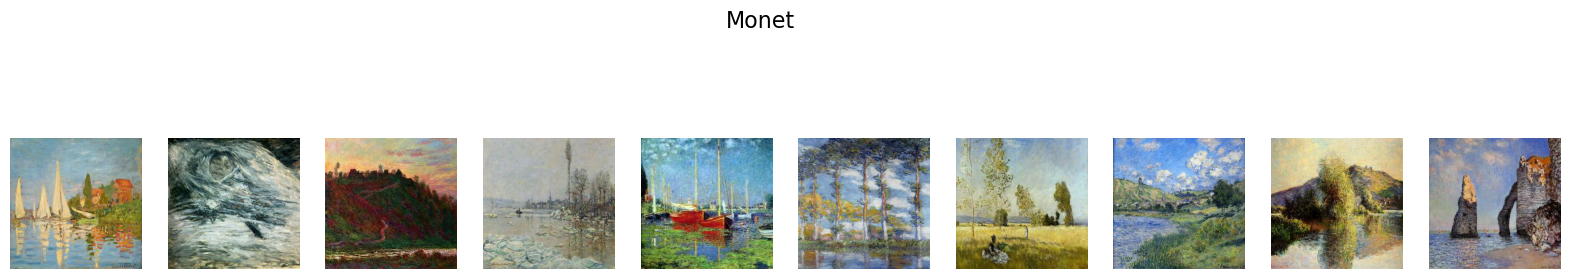

In [2]:
images_path = os.path.join(data_path, 'monet_jpg')
photo_path = os.path.join(data_path, 'photo_jpg')

sample_monet_images = os.listdir(images_path)[:10]
fig, axes = plt.subplots(1, 10, figsize=(20, 4))
for img_name, ax in zip(sample_monet_images, axes):
    img = Image.open(os.path.join(images_path, img_name))
    ax.imshow(img)
    ax.axis('off')
fig.suptitle('Monet', fontsize=16)
plt.show()

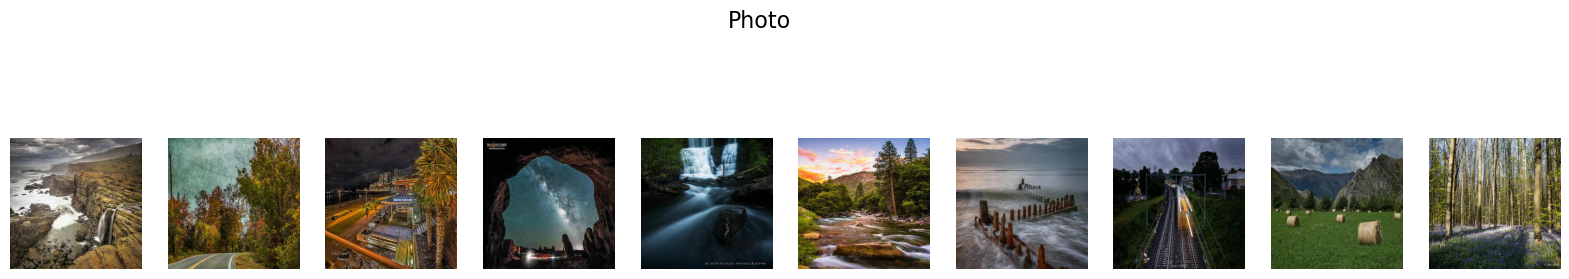

In [3]:
images_path = os.path.join(data_path, 'photo_jpg')

sample_images = os.listdir(images_path)[:10]
fig, axes = plt.subplots(1, 10, figsize=(20, 4))
for img_name, ax in zip(sample_images, axes):
    img = Image.open(os.path.join(images_path, img_name))
    ax.imshow(img)
    ax.axis('off')
fig.suptitle('Photo', fontsize=16)
plt.show()


In [4]:
def load_and_preprocess_data():
    (train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
    train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
    train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]
    return train_images

## Model Architecture (25 pts)

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

def build_generator():
    model = Sequential()
    model.add(Dense(256, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    model.add(Reshape((28, 28, 1)))
    return model


In [14]:
from tensorflow.keras.layers import Conv2D, Flatten, Dropout

def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28, 1)))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model


In [19]:
def train_gan(generator, discriminator, combined, epochs, batch_size):
    train_images = load_and_preprocess_data()
    for epoch in range(epochs):
        # Training the discriminator
        idx = np.random.randint(0, train_images.shape[0], batch_size)
        real_images = train_images[idx]
        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict(noise)
        d_loss_real = discriminator.train_on_batch(real_images, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((batch_size, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Training the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

        # Print the progress
        print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}] [G loss: {g_loss}]")
        if epoch % 100 == 0:
            save_images(epoch, generator)

In [20]:
def save_images(epoch, generator, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, (examples, 100))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"gan_generated_image_epoch_{epoch}.png")
    plt.close()

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_gan(generator, discriminator):
    discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    discriminator.trainable = False

    gan_input = tf.keras.Input(shape=(100,))
    generated_image = generator(gan_input)
    gan_output = discriminator(generated_image)

    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

In [22]:
generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)
train_gan(generator, discriminator, gan, epochs=10, batch_size=64)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


/Users/chenliyang1024/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.2892528176307678, acc.: 80.859375] [G loss: [array(0.43665218, dtype=float32), array(0.43665218, dtype=float32), array(0.6171875, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1 [D loss: 0.5941272974014282, acc.: 65.16927480697632] [G loss: [array(0.8497988, dtype=float32), array(0.8497988, dtype=float32), array(0.55859375, dtype=float32)]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2 [D loss: 1.0374614000320435, acc.: 59.296876192092896] [G loss: [array(1.3631002, dtype=float32), array(1.3631002, dtype=float32), array(0.5390625, dtype=float32)]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3 [D loss: 1.5541434288024902, acc.: 56.71038031578064] [G loss: [array(1.9178674, dtype=float32), array(1.9178674, dtype=float32), array(0.5292969, dtype=float32)]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4 [D loss: 2.079007863998413, acc.: 55.25173544883728] [G loss: [array(2.4370875, dtype=float32), array(2.4370875, dtype=float32), array(0.5234375, dt

In [27]:
sample_images

['5a384bf8d9.jpg',
 'bb15fcc4ff.jpg',
 '39c1270676.jpg',
 '506fdcb3c1.jpg',
 '63f6cea734.jpg',
 '7b95afc20a.jpg',
 '0723d52098.jpg',
 '3be1aea5fc.jpg',
 '114692dc5b.jpg',
 'd665568cdf.jpg']

In [28]:
def load_real_image_sample(image_path):
    # Load the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)

    # Resize the image to the desired size (256x256)
    image = tf.image.resize(image, [256, 256])

    # Normalize the image to [-1, 1] range
    image = (image / 127.5) - 1

    return image.numpy()

image_path = './gan-getting-started/photo_jpg/5a384bf8d9.jpg'  # Replace with your image path
real_image = load_real_image_sample(image_path)

In [29]:
def visualize_generated_image(generator, real_image):
    generated_image = generator.predict(np.expand_dims(real_image, axis=0))[0]
    plt.imshow((generated_image + 1) / 2)
    plt.show()

In [31]:
# real_image = load_real_image_sample()
visualize_generated_image(gan, real_image)

ValueError: Input 0 of layer "functional_43" is incompatible with the layer: expected shape=(None, 100), found shape=(1, 256, 256, 3)